# Prepare for synthesized Temporal Sequence Datasets

In [1]:
import numpy as np
import json
import os

from collections import Counter

## Rules of version 6

Sequence length T = 20;

Token Types (Token-Encoding-meaning): 

P-0-padding

N-1-initial token

A-2-start

B-3-view

C-4-click

D-5-install


In order to be positive, a temporal sequence MUST NOT violate any of the following rules / hidden patterns:

0. __[Increasing time]__: Timestamp must be strictly increasing. A later event must have a greater timestamp then any previous event. Since delta_t is used for data generation, timestamp will always increasing, so __this rule is NOT used for oracle__

1. __[Starting with A]__: A sequence must start with an A event.

2. __[Not Only A]__: There must be a non-A token after the init token.

3. __[Pairing C & D]__: Each C event can either appear alone, or be paired with one and only one later D event. Each D event has to be paired with one and only one previous C event. Pairing can be non-unique. 

4. __[Number Decay]__: The total number of A's must be greater than B; The total number of B's must be >= the nums of C; The total number of C's must be >= the nums of D.

5. __[Minimum Same Delay]__: The minimum time delay between two consecutive __same__ tokens is 5 secs

6. __[Maximum Pair Delay]__: The time delay between the pair C and D cannot be > 100 secs

## Timestamp distributions conditioned on the upcoming event

In [2]:
# the ts distribution is conditioned on the upcoming event
# e.g. if the upcoming event is an A, it follows chi-square 8 distribution
event_to_ts_dist = dict({
    'A' : lambda: np.random.chisquare(df=8),
    'B' : lambda: np.random.chisquare(df=16),
    'C' : lambda: np.random.chisquare(df=24),
    'D' : lambda: np.random.chisquare(df=32),
})

## Define the Context and Rules

In [21]:
# EVENT_TYPES = {0:'':'A', 3:'B', 4:'C'} # 0 is reserved for padding 1 is for 'init token'
EVENT_TYPES = ['P', 'N', 'A', 'B', 'C', 'D']
EVENT_ENCODE = {'P':0, 'N':1, 'A':2, 'B':3, 'C':4, 'D':5}
INIT_TOKEN = EVENT_ENCODE['N']

MIN_SAME_DELAY = 5
MAX_PAIR_DELAY = 100

def check_increasing_rule(seq):
    for i in range(1, len(seq)):
        if seq[i][1] <= seq[i-1][1]:
            return False
    return True


def check_rule_1(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    return seq[0][0] == EVENT_ENCODE['A']
        
    
def check_rule_2(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    cnt = Counter()
    for et, ts in seq:
        cnt[et] += 1
    # rule 2
    if cnt.keys() == set(['A']):
        return False
    return True


def check_rule_3(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0


def check_rule_4(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    cnt = Counter()
    for et, ts in seq:
        cnt[et] += 1
    # rule 4
    if cnt[EVENT_ENCODE['A']] < EVENT_ENCODE['B']:
        return False
    if cnt[EVENT_ENCODE['B']] < EVENT_ENCODE['C']:
        return False
    if cnt[EVENT_ENCODE['C']] < EVENT_ENCODE['D']:
        return False
    return True


def check_rule_5(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    prev_et, prev_ts = EVENT_ENCODE['N'], 0.0
    for et, ts in seq[1:]:
        if et == prev_et and ts - prev_et < MIN_SAME_DELAY:
            return False
    return True


def check_rule_6(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if seq[queue[0]][1] - seq[i][1] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True

## Create Uniform-length Dataset: generate valid and invalid sequences

In [22]:
from collections import defaultdict

# length of a temporal sequence
L = 20

# size of the dataset
N = 10000

all_seqs = []
seq_to_rules = defaultdict(list)
# neg_seqs = []

use_init_token = True

for i in range(N):
    seq_len = np.random.binomial(n=L, p=0.6)
    
    # Generate the time sequences only
    type_seq = [INIT_TOKEN] + np.random.randint(low=EVENT_ENCODE['A'], high=EVENT_ENCODE['D']+1, size=seq_len).tolist()
    
    # Generate a seq of timestamps. Time delta conditions on the upcoming token
    dts = []
    for et in type_seq[1:]:
        token = EVENT_TYPES[et]
        dt_dist = event_to_ts_dist[token]
        dt_sample = float(np.ceil(dt_dist()))
        dts.append(dt_sample) 
    time_seq = [0.0] + dts
        
    seq = list(zip(type_seq, time_seq))
    
    # check rules one by one:
    if check_rule_1(seq):
        seq_to_rules[i].append(1)
    if check_rule_2(seq):
        seq_to_rules[i].append(2)
    if check_rule_3(seq):
        seq_to_rules[i].append(3)
    if check_rule_4(seq):
        seq_to_rules[i].append(4)
    if check_rule_5(seq):
        seq_to_rules[i].append(5)
    if check_rule_6(seq):
        seq_to_rules[i].append(6)            
        
    all_seqs.append(seq)

In [23]:
all_seqs

[[(1, 0.0),
  (2, 7.0),
  (4, 17.0),
  (4, 18.0),
  (5, 22.0),
  (4, 23.0),
  (4, 29.0),
  (4, 50.0),
  (2, 10.0),
  (4, 19.0),
  (2, 16.0),
  (5, 35.0)],
 [(1, 0.0),
  (3, 18.0),
  (5, 40.0),
  (2, 15.0),
  (5, 35.0),
  (2, 11.0),
  (4, 33.0),
  (5, 32.0),
  (3, 9.0),
  (5, 28.0),
  (2, 8.0),
  (3, 24.0),
  (5, 28.0),
  (3, 23.0),
  (3, 18.0),
  (5, 28.0),
  (2, 10.0)],
 [(1, 0.0),
  (2, 4.0),
  (5, 34.0),
  (3, 12.0),
  (5, 35.0),
  (5, 29.0),
  (3, 21.0),
  (4, 39.0),
  (3, 18.0),
  (5, 25.0),
  (2, 11.0),
  (4, 24.0)],
 [(1, 0.0),
  (5, 40.0),
  (5, 27.0),
  (5, 43.0),
  (4, 24.0),
  (2, 5.0),
  (5, 27.0),
  (4, 26.0),
  (3, 11.0),
  (2, 3.0),
  (3, 17.0)],
 [(1, 0.0),
  (3, 15.0),
  (2, 10.0),
  (2, 5.0),
  (4, 21.0),
  (3, 8.0),
  (4, 38.0),
  (4, 29.0),
  (5, 36.0),
  (4, 20.0),
  (2, 14.0),
  (2, 2.0),
  (5, 23.0),
  (2, 7.0)],
 [(1, 0.0),
  (2, 16.0),
  (3, 20.0),
  (5, 32.0),
  (2, 11.0),
  (4, 25.0),
  (5, 28.0),
  (5, 36.0),
  (5, 27.0),
  (3, 10.0),
  (3, 17.0)],
 [(1, 0.0

In [24]:
seq_to_rules

defaultdict(list,
            {0: [1, 2, 3, 5, 6],
             1: [2, 5, 6],
             2: [1, 2, 5, 6],
             3: [2, 5, 6],
             4: [2, 3, 5, 6],
             5: [1, 2, 5, 6],
             6: [1, 2, 5, 6],
             7: [2, 3, 5, 6],
             8: [2, 5, 6],
             9: [2, 5, 6],
             10: [1, 2, 5, 6],
             11: [1, 2, 5, 6],
             12: [2, 3, 5, 6],
             13: [2, 5, 6],
             14: [1, 2, 5, 6],
             15: [2, 3, 5, 6],
             16: [2, 5, 6],
             17: [2, 5, 6],
             18: [2, 5, 6],
             19: [2, 3, 5, 6],
             20: [2, 5, 6],
             21: [2, 5, 6],
             22: [2, 5, 6],
             23: [1, 2, 5, 6],
             24: [2, 5, 6],
             25: [2, 3, 5, 6],
             26: [2, 3, 5, 6],
             27: [2, 5, 6],
             28: [2, 3, 5, 6],
             29: [1, 2, 3, 5, 6],
             30: [2, 5, 6],
             31: [2, 5, 6],
             32: [2, 5, 6],
           

## Divide pos and neg sequences by rule 1 and rule 2

In [103]:
pos_seqs = []
neg_seqs = []

for i in range(N):
    if 6 not in seq_to_rules[i]:
        print(i)
    
    if 1 in seq_to_rules[i] and 2 in seq_to_rules[i]:
        pos_seqs.append(all_seqs[i])
    else:
        neg_seqs.append(all_seqs[i])

In [26]:
print(len(pos_seqs))

2538


In [27]:
print(len(neg_seqs))

7462


In [ ]:
seq_to_rules

## Padding and trimming

In [31]:
def add_paddings(seq, T=21, inplace=False):
    if inplace:
        while len(seq) < T:
            seq.append((0, 0.0))
        return
    else:
        seq_copy = list(seq)
        while len(seq_copy) < T:
            seq_copy.append((0, 0.0))
        return seq_copy
    
def trim_paddings(seq, T=21, inplace=False):
    if inplace:
        while seq and seq[-1] == (0, 0.0):
            seq.pop()
        return
    else:
        seq_copy = list(seq)
        while seq_copy and seq_copy[-1] == (0, 0.0):
            seq_copy.pop()
        return seq_copy

In [95]:
padded_pos_seqs = [add_paddings(seq) for seq in pos_seqs]
padded_neg_seqs = [add_paddings(seq) for seq in neg_seqs]
padded_all_seqs = padded_pos_seqs + padded_neg_seqs

In [96]:
trimmed_pos_seqs = [trim_paddings(seq) for seq in padded_pos_seqs]
trimmed_neg_seqs = [trim_paddings(seq) for seq in padded_neg_seqs]

## Save Dataset : Dump into binay files 

In [97]:
# # Downsample the negative seqs
# random_idx = np.arange(len(neg_seqs))
# np.random.shuffle(random_idx)

# # random_idx

# neg_seqs_downsample = neg_seqs[:len(pos_seqs)]
# len(neg_seqs_downsample)

In [98]:
import pickle

pos_seqs_filename = 'positive_long_sequences.pickle'
neg_seqs_filename = 'negative_long_sequences.pickle'
all_seqs_filename = 'all_long_sequences.pickle'

repo_path = '/home/lun/project-basileus/seq-gan/'

with open(os.path.join(repo_path, 'data', 'long_seqs_v6', pos_seqs_filename), 'wb') as f:
    pickle.dump(padded_pos_seqs, f)
    
with open(os.path.join(repo_path, 'data', 'long_seqs_v6', neg_seqs_filename), 'wb') as f:
    pickle.dump(padded_neg_seqs, f)
    
with open(os.path.join(repo_path, 'data', 'long_seqs_v6', all_seqs_filename), 'wb') as f:
    pickle.dump(padded_all_seqs, f)

## Create Oracle

In [72]:
def calculate_FID_batch(batch1, batch2, weight):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:     
    -- batch1   : (batch_size, T, 2) The first batch of sequences to be compared with the second one
    -- batch2   : (batch_size, T, 2) The second batch.
    Returns:
    --   : The Frechet Distance.
    """
    # mu1: Numpy array containing the activations of a layer of the
    #      inception net (like returned by the function 'get_predictions')
    #      for generated samples.
    # mu2: The sample mean over activations, precalculated on an
    #      representative data set.
    # sigma1: The covariance matrix over activations for generated samples.
    # sigma2: The covariance matrix over activations, precalculated on an
    # representative data set.
    
    n1, T1, _ = batch1.shape
    n2, T2, _ = batch2.shape
    
    assert T1 == T2
    
    batch1_et, batch1_ts = batch1[:, :, 0], batch1[:, :, 1]
    batch2_et, batch2_ts = batch2[:, :, 0], batch2[:, :, 1]
    
    def fid(batch1_feature, batch2_feature):
        mu1, sigma1 = batch1_feature.mean(axis=0), np.cov(batch1_feature, rowvar=False)
        mu2, sigma2 = batch2_feature.mean(axis=0), np.cov(batch2_feature, rowvar=False)
        ssdiff = np.sum((mu1 - mu2)**2.0)

        # calculate sqrt of product between cov
        covmean = np.sqrt((sigma1+0j).dot((sigma2+0j)))

        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        
        return fid
    
    fid_ts = fid(batch1_ts, batch2_ts)
    fid_et = fid(batch1_et, batch2_et)

    return fid_ts + weight * fid_et

In [ ]:
# def calculate_FID_batch(batch1, batch2, weight):
#     """Numpy implementation of the Frechet Distance.
#     The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
#     and X_2 ~ N(mu_2, C_2) is
#             d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
#     Stable version by Dougal J. Sutherland.
#     Params:
#     -- batch1   : The first batch of sequences to be compared with the second one
#     -- batch2   : The second batch.
#     Returns:
#     --   : The Frechet Distance.
#     """
#     # mu1: Numpy array containing the activations of a layer of the
#     #      inception net (like returned by the function 'get_predictions')
#     #      for generated samples.
#     # mu2: The sample mean over activations, precalculated on an
#     #      representative data set.
#     # sigma1: The covariance matrix over activations for generated samples.
#     # sigma2: The covariance matrix over activations, precalculated on an
#     # representative data set.
#     n1 = len(batch1)
#     n2 = len(batch2)
#     seqlen = len(batch1[0]) #seq
#     b_tok1 = []
#     b_tok2 = []
#     b_ts1 = []
#     b_ts2 = []
#     for elem in batch1:
#         tok = []
#         ts = []
#         for seq in elem:
#             tok.append(seq[0])
#             ts.append(seq[1])
#         b_tok1.append(tok)
#         b_ts1.append(ts)
#     for elem in batch2:
#         tok = []
#         ts = []
#         for seq in elem:
#             tok.append(seq[0])
#             ts.append(seq[1])
#         b_tok2.append(tok)
#         b_ts2.append(ts)      
#     tok1, tok2 = np.array(b_tok1), np.array(b_tok2)
#     ts1, ts2 = np.array(b_ts1), np.array(b_ts2)
#     mu1, sigma1 = ts1.mean(axis=0), np.cov(ts1, rowvar=False)
#     mu2, sigma2 = ts2.mean(axis=0), np.cov(ts2, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2)**2.0)
#     # calculate sqrt of product between cov
#     covmean = sqrtm(sigma1.dot(sigma2))
#     # check and correct imaginary numbers from sqrt
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
#     # calculate score
#     fid1 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     mu1, sigma1 = tok1.mean(axis=0), np.cov(tok1, rowvar=False)
#     mu2, sigma2 = tok2.mean(axis=0), np.cov(tok2, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2)**2.0)
#     # calculate sqrt of product between cov
#     covmean = sqrtm(sigma1.dot(sigma2))
#     # check and correct imaginary numbers from sqrt
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
#     # calculate score
#     fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid1 + weight * fid2

In [62]:
def get_oracle_score(seq, reference_batch, use_init_token=True):
    score = 0
    
    if use_init_token:
        seq = seq[1:]
        
    
    
    # if the seq follows starting rule, add 0.5 points to score
    score += 0.5 * int(seq[0][0] == EVENT_ENCODE['A'])
    
    # The rest 0.5 points is weighted by (number of paired D events) / (number of total D events)
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    total_D = 0
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
            total_D += 1
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if seq[queue[0]][1] - seq[i][1] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else: # ealy-stopping, since no possible B in future can be pair with the C on top of the queue
                return False
    unmatched_D = len(queue)
    
    if total_D > 0:
        score += 0.5 * (1 - unmatched_D / total_D)
    else:
        # if no C event, the seq can easily be valid
        # but we penalize this case by reducing total score by 0.05
        # to encourage the GAN generator to generate D events
        score += 0.45 
    
    return score

## Test Oracle

In [63]:
import numpy as np
import matplotlib.pyplot as plt

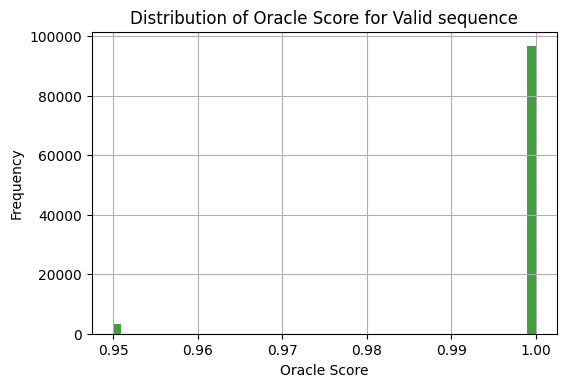

In [64]:
scores_for_valid_dataset = np.array([get_oracle_score(seq) for seq in pos_seqs])

x = scores_for_valid_dataset

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for Valid sequence')
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

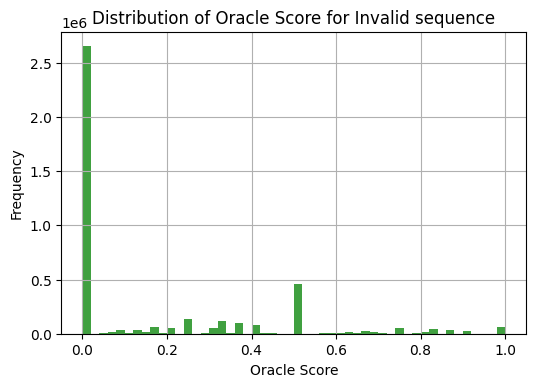

In [65]:
scores_for_invalid_dataset = np.array([get_oracle_score(seq) for seq in neg_seqs])

x = scores_for_invalid_dataset

plt.figure(dpi=100)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Oracle Score')
plt.ylabel('Frequency')
plt.title('Distribution of Oracle Score for Invalid sequence')
# plt.xlim(0, 1.1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

## Debugging Section

In [71]:
neg_seqs_downsample[0]

[(1, 0.0),
 (2, 3.0),
 (5, 24.0),
 (2, 30.0),
 (2, 35.0),
 (5, 67.0),
 (5, 119.0),
 (2, 131.0),
 (5, 163.0),
 (3, 175.0),
 (2, 185.0),
 (4, 214.0),
 (2, 226.0),
 (4, 249.0),
 (3, 274.0),
 (5, 302.0),
 (4, 335.0),
 (3, 348.0),
 (3, 370.0),
 (3, 385.0),
 (5, 414.0)]

In [74]:
pos_seqs[1]

[(1, 0.0),
 (2, 17.0),
 (4, 34.0),
 (2, 42.0),
 (3, 60.0),
 (2, 70.0),
 (4, 91.0),
 (2, 96.0),
 (5, 118.0),
 (4, 141.0),
 (4, 182.0),
 (2, 187.0),
 (3, 203.0),
 (3, 218.0),
 (3, 232.0),
 (4, 250.0),
 (2, 259.0),
 (4, 286.0),
 (4, 303.0),
 (2, 319.0),
 (3, 341.0)]

In [78]:
et1 = [et for et, ts in pos_seqs[1]]

In [79]:
from collections import Counter
Counter(et1)

Counter({1: 1, 2: 7, 4: 7, 3: 5, 5: 1})

In [80]:
!pwd


/home/lun/project-basileus/seq-gan/notebook


In [56]:
batch1 = np.array(padded_neg_seqs)
batch2 = np.array(padded_pos_seqs)

In [83]:
n1, T1, _ = batch1.shape
n2, T2, _ = batch2.shape

assert T1 == T2

batch1_et, batch1_ts = batch1[:, :, 0], batch1[:, :, 1]
batch2_et, batch2_ts = batch2[:, :, 0], batch2[:, :, 1]

batch1_feature = batch1_ts
batch2_feature = batch2_ts


mu1, sigma1 = batch1_feature.mean(axis=0), np.cov(batch1_feature, rowvar=False)
mu2, sigma2 = batch1_feature.mean(axis=0), np.cov(batch1_feature, rowvar=False)
ssdiff = np.sum((mu1 - mu2)**2.0)

# calculate sqrt of product between cov
covmean = np.sqrt((sigma1+0j).dot((sigma2+0j)))

# check and correct imaginary numbers from sqrt
if np.iscomplexobj(covmean):
    covmean = covmean.real

# calculate score
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)


# def fid(batch1_feature, batch2_feature):
#     mu1, sigma1 = batch1_feature.mean(axis=0), np.cov(batch1_feature, rowvar=False)
#     mu2, sigma2 = batch2_feature.mean(axis=0), np.cov(batch2_feature, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2)**2.0)

#     # calculate sqrt of product between cov
#     covmean = np.sqrt(sigma1.dot(sigma2))
#     print(covmean)

#     # check and correct imaginary numbers from sqrt
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real

#     # calculate score
#     fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

#     return fid

# fid_ts = fid(batch1_ts, batch2_ts)
# fid_et = fid(batch1_et, batch2_et)

In [85]:
np.trace(sigma1 + sigma2 - 2.0 * covmean)

-379.5114118855246

In [67]:
sigma1.dot(sigma2).shape

(21, 21)

array([[ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  6.65389104e-01+0.j,  1.01314830e-03+0.j,
         1.63802366e-02+0.j, -1.96481365e-03+0.j,  4.37748462e-03+0.j,
        -6.59489382e-03+0.j, -6.62494377e-03+0.j,  8.08934414e-03+0.j,
        -9.25601118e-03+0.j, -1.51576189e-02+0.j,  5.78618573e-03+0.j,
        -1.44931254e-02+0.j, -1.81873824e-02+0.j, -6.45495413e-03+0.j,
        -6.49795447e-03+0.j,  3.41312033e-03+0.j,  1.77709581e-03+0.j,
        -1.09311384e-03+0.j,  2.48949321e-05+0.j,  0.00000000e+00+0.j],
    